# Branch Support Plots

---
## Setup

### Import modules

In [61]:
import os
from Bio import Phylo
import matplotlib.pyplot as plt
from matplotlib import gridspec, lines
import seaborn as sns

import pandas as pd

### Input file paths

In [17]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.xml"
tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
outdir = "../../docs/results/latest/branch_support/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [34]:
NO_DATA_CHAR = "NA"
ALRT_THRESH = 80
UFBOOT_THRESH = 95

### Plotting Configuration

In [38]:
# Colors
HIGH_COL = "red"
LOW_COL = "black"
TERM_COL = "grey"
THRESH_COL = "blue"
COLOR_PAL = "rainbow"
COLBAR_MAX_ROW = 10

# Graphics
figsize=(6.4,4.8)
figsize_alt=(9.6,4.8)
dpi=400

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
#plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels

# Lines
plt.rc('lines', linewidth=0.5)

orig_rcParams = plt.rc

### Read input tree

In [54]:
# Note: reading phyloxml seems not to like the other attributes

tree = Phylo.read(tree_path, "phyloxml")
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

---
## Plotting

In [55]:
data = tree_df[(tree_df['aLRT'] != NO_DATA_CHAR) & (tree_df['UFboot'] != NO_DATA_CHAR) ]

### Color branches according to branch support

In [58]:
for c in tree.find_clades():
    if not c.name: continue
    c.color = tree_df["Branch_Support_Color"][c.name]

1

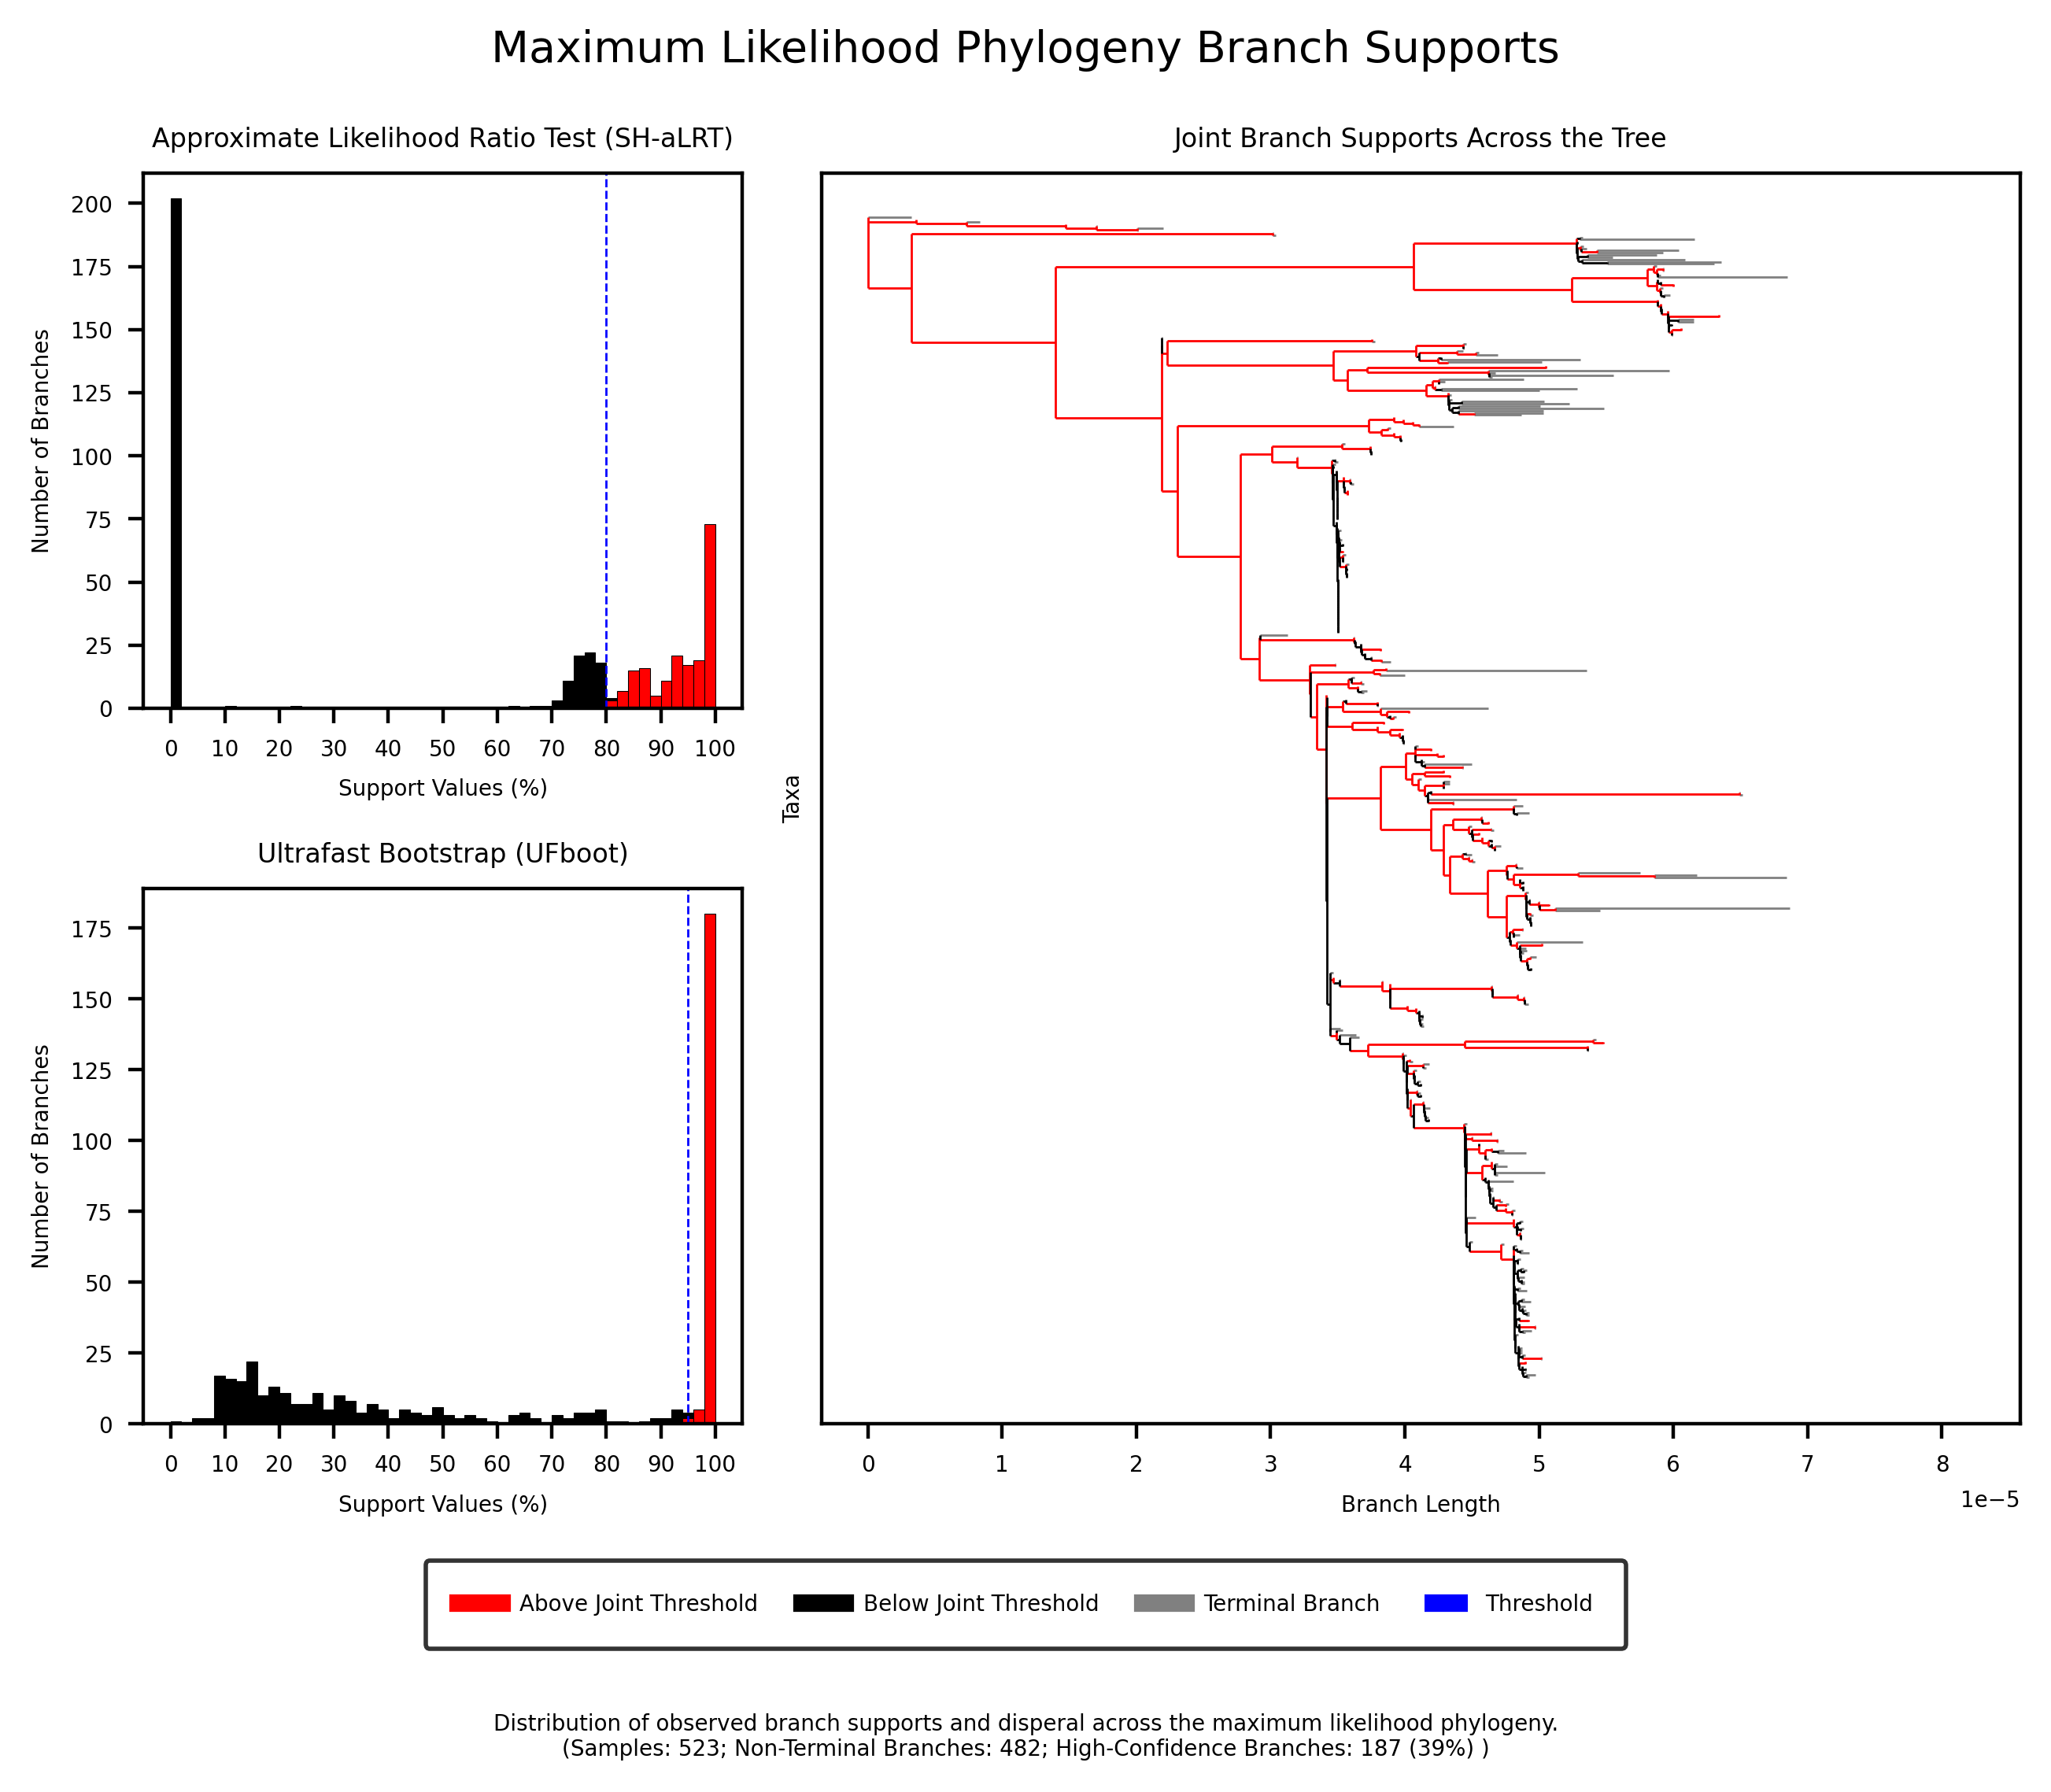

In [60]:
fig = plt.figure(constrained_layout=True, 
                 dpi=dpi,
                 figsize=figsize)

# Setup the grid
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0:, 1:3])

# Local plot variables
hist_bins = [x for x in range(0,101,2)]
xticks_major = [x for x in range(0,101,10)]

# Filter out NA values
data = tree_df[(tree_df['aLRT'] != NO_DATA_CHAR) & (tree_df['UFboot'] != NO_DATA_CHAR) ]

# -------------------------------
# aLRT Axis
sns.histplot(data, 
             x="aLRT", 
             ax=ax1,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[HIGH_COL, LOW_COL],
             legend=False,
             alpha=1)
ax1.axvline(x=ALRT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax1.set_xticks(xticks_major, minor=False)
ax1.set_xticklabels(xticks_major)
ax1.set_xlabel("Support Values (%)")
ax1.set_ylabel('Number of Branches')
ax1.set_title('Approximate Likelihood Ratio Test (SH-aLRT)')

# -------------------------------
# UFboot Axis
sns.histplot(data, 
             x="UFboot", 
             ax=ax2,
             bins=hist_bins,
             hue="Branch_Support_Color",
             palette=[HIGH_COL, LOW_COL],
             legend=False,
             alpha=1)
ax2.axvline(x=UFBOOT_THRESH, color=THRESH_COL, linewidth=0.5, linestyle='--')
ax2.set_xticks(xticks_major, minor=False)
ax2.set_xticklabels(xticks_major)
ax2.set_ylabel('Number of Branches')
ax2.set_xlabel("Support Values (%)")
ax2.set_title('Ultrafast Bootstrap (UFboot)')

# -------------------------------
# Phylogeny
tree.ladderize(reverse=True)

Phylo.draw(tree,
           axes=ax3,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

ax3.set_xlabel('Branch Length')
ax3.set_ylabel('Taxa')
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.set_ylim(-20,len(tree.get_terminals())+20)
ax3.set_title("Joint Branch Supports Across the Tree")

# -------------------------------
# Figure title
fig.suptitle("Maximum Likelihood Phylogeny Branch Supports")

# -------------------------------
# Legend
legend_lines = [lines.Line2D([0], [0], color=HIGH_COL, lw=4),
                lines.Line2D([0], [0], color=LOW_COL, lw=4),
                lines.Line2D([0], [0], color=TERM_COL, lw=4),
                lines.Line2D([0], [0], color=THRESH_COL, lw=4, ls="--"),
               ]

legend_labels = ["Above Joint Threshold",
                 "Below Joint Threshold",
                 "Terminal Branch",
                 "Threshold"]

fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           frameon=True,
           borderpad=1.5,
           edgecolor="black")

# -------------------------------
# Caption
num_terminal_nodes = len(tree_df[tree_df["Branch_Support_Color"] == TERM_COL])
num_internal_nodes = len(tree_df[tree_df["Branch_Support_Color"] != TERM_COL])
num_high_support = len(tree_df[tree_df["Branch_Support_Color"] == HIGH_COL])
num_low_support = len(tree_df[tree_df["Branch_Support_Color"] == LOW_COL])
perc_high_support = (num_high_support / num_internal_nodes) * 100

caption_text = ("Distribution of observed branch supports and disperal across the maximum likelihood phylogeny." 
                + "\n(" 
                + "Samples: {}".format(num_terminal_nodes) 
                + "; "
                + "Non-Terminal Branches: {}".format(num_internal_nodes)
                + "; "
                + "High-Confidence Branches: {0} ({1:.0f}%)".format(num_high_support, perc_high_support)
                + " )"
               )
fig.text(0.5, -0.15, caption_text, ha='center')

# -------------------------------
# Save figure
out_path = os.path.join(outdir, "branch_support.jpg") 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# Save Tree File
out_path = os.path.join(outdir, "branch_support.xml" )
Phylo.write(tree, 
            out_path,
            "phyloxml")

### Annotations (TBD)

In [ ]:
"""
# -------------------------------
# Annotations
first_pandemic_mrca = tree_div.common_ancestor("SAMEA4354665", "SAMEA1061800").name # AE1175, DA101
second_pandemic_mrca = tree_div.common_ancestor("SAMN00715800","SAMEA3713715", "SAMEA5818822").name # 8291, OBS137, STN008

annot_dict = {"First Pandemic": {"node": first_pandemic_mrca},
              "Second Pandemic": {"node": second_pandemic_mrca},
             }

for annot in annot_dict:
    # Find clade that matches annotation
    annot_clade = next(tree_div.find_clades(target=annot_dict[annot]["node"]))    
    annot_x = tree_df["coord_x"][annot_clade.name]
    annot_y = tree_df["coord_y"][annot_clade.name]
    ax3.text(tree_df["coord_x"][annot_clade.name] + x_offset,
             tree_df["coord_y"][annot_clade.name] + y_offset, 
             annot,)
    ax3.annotate('Test annot', 
                xy=(annot_x, annot_y),  
                xycoords='data',
                xytext=(annot_x, 0+annot_y/tree_div.count_terminals()), 
                textcoords='axes fraction',
                arrowprops=dict(facecolor='black', 
                shrink=0.05),
                horizontalalignment='right', 
                verticalalignment='top',
                )
    """

In [69]:
sns.color_palette("husl", 10)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.962272393509669, 0.3976451968965351, 0.8008274363432775)]